In [1]:
!pip install timm

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

import timm

import numpy as np
from tqdm.notebook import tqdm
import glob
import os
import matplotlib.pyplot as plt
import cv2

In [3]:
train_dir = "../input/10-monkey-species/training/training/"
valid_dir = "../input/10-monkey-species/validation/validation/"

train_image_dirs = glob.glob(train_dir + "/*/*.*")
valid_image_dirs = glob.glob(valid_dir + "/*/*.*")


unique_labels = os.listdir(train_dir)
print(unique_labels)

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
print(DEVICE)

In [6]:
print(train_image_dirs)

# Dataset Class 
expects 3 functions:
* init function : takes all necessary inputs
* len function :  returns length of the dataset
* getitem function : returns input and label that can be fed to neural network

In [7]:
class BIRD_SPECIES(Dataset):
    def __init__(self, train_dirs, labels):
        #get all necessary inputs like train directories and labels
        self.train_dirs = train_dirs
        self.labels = labels
        self.labels = np.asarray(self.labels)

        
    def __len__(self,):
        #return len of the dataset
        return len(self.train_dirs)
    
    def get_one_hot_encoding(self, cat):
        one_hot = np.asarray(cat == self.labels)
        return one_hot
        
    def __getitem__(self, idx):
        #get data for one id value..pytorch will handle the batching for you!
        train_img_dir = self.train_dirs[idx]
        label = train_img_dir.split("/")[-2]
        
        #print(train_img_dir)
        img = cv2.imread(train_img_dir)
        img = cv2.resize(img, (256, 256))
        one_hot = self.get_one_hot_encoding(label)
        
        img = img.transpose((2, 0, 1))
        img = torch.tensor(img, dtype = torch.float)
        one_hot = torch.tensor(one_hot, dtype = torch.float)
        return img/255.0, one_hot
    
    
train_dataset = BIRD_SPECIES(train_image_dirs, unique_labels)
valid_dataset = BIRD_SPECIES(valid_image_dirs, unique_labels)
img, label = train_dataset.__getitem__(1000)
img = img.numpy().transpose(1,2,0)
plt.imshow(img)
print(label)


In [8]:
print(unique_labels)

In [9]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size = 8,
    shuffle = True
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size = 8,
    shuffle = True
)

# Convolutions: 
### here is a brief animation on how convolutions work


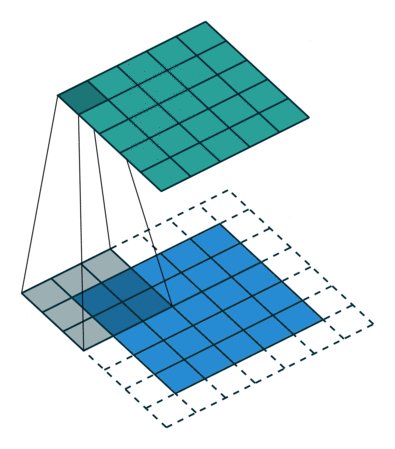

## formula for output size:

#### **$$outputSize = ((inputSize + 2*padding -filterSize)/stride + 1)$$**

# Famous convolutional neural network architectures
#### 1. *Family of ResNets* [link](https://arxiv.org/abs/1512.03385)
#### 2. *Family of EfficientNets* [link](https://arxiv.org/abs/1905.11946)
#### 3. *Family of EfficientNetv2* [link](https://arxiv.org/abs/2104.00298)

In [10]:
timm.list_models()

In [15]:
class MonkeySpeciesClassifier(nn.Module):
    def __init__(self, num_classes):
        #define necessary layers
        super().__init__()
        self.num_classes = num_classes      
        self.model = timm.create_model(model_name = "resnet34", pretrained = True)
        self.model.fc = nn.Linear(self.model.fc.in_features, out_features = num_classes)

        
    def forward(self,X):
        #define forward pass here
        return F.softmax(self.model(X), dim=-1)
    
model = MonkeySpeciesClassifier(len(unique_labels)).to(DEVICE)
print(model(torch.zeros((1, 3, 256, 256)).to(DEVICE)).shape)

In [16]:
print(model.model)

# Optimizer And Loss Function

In [17]:
optimizer = Adam(lr = 0.001, params = model.parameters())

def loss_fn(y_pred, y_true):
    #define your loss function here
    y_pred = torch.clip(y_pred, 1e-8, 1-1e-8)
    l = y_true*torch.log(y_pred)
    l = l.sum(dim = -1)
    l = l.mean()
    return -l

In [19]:
def train_on_one_epoch(dataloader, optimizer, loss_fn, len_dataloader):
    #training for one epoch
    
    dataloader = tqdm(dataloader)
    L = 0
    acc = 0
    for i,(x, y) in enumerate(dataloader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        y_pred = model(x)
        l = loss_fn(y_pred, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        L+=l.item()
        acc+=np.sum(y_pred.cpu().detach().numpy().argmax(-1) == y.cpu().detach().numpy().argmax(-1))
    return L/len_dataloader, acc/len_dataloader
        
        

def valid_on_one_epoch(dataloader, loss_fn, len_dataloader):
    #validation for one epoch
    dataloader = tqdm(dataloader)
    L = 0
    acc = 0
    for i,(x, y) in enumerate(dataloader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        y_pred = model(x)
        l = loss_fn(y_pred, y)
        L+=l.item()
        acc+=np.sum(y_pred.cpu().detach().numpy().argmax(-1) == y.cpu().detach().numpy().argmax(-1))
        
    return L/len_dataloader, acc/len_dataloader

prev_valid_acc = 0
for epoch in range(10):
    train_loss, train_acc = train_on_one_epoch(train_dataloader, optimizer, loss_fn, len(train_dataset))
    valid_loss, valid_acc = valid_on_one_epoch(valid_dataloader, loss_fn, len(valid_dataset))
    print(f"epoch : {epoch} | train loss : {train_loss} | valid_loss : {valid_loss} | train_acc : {train_acc} | valid_acc : {valid_acc}")
    if prev_valid_acc<valid_acc:
        print("model saved..!!")
        torch.save(model.state_dict(), "best.pt")
        prev_valid_acc = valid_acc